# Limpieza

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import numpy as np

In [2]:
df_train = pd.read_csv("../data/train_set.csv")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28821 entries, 0 to 28820
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id_img  28821 non-null  int64 
 1   path    28821 non-null  object
 2   label   28821 non-null  object
dtypes: int64(1), object(2)
memory usage: 675.6+ KB


El train tiene 3 columnas. La primera el id, la segunda el path y la tercera nuestro target que es la label

In [3]:
df_test = pd.read_csv("../data/test_set.csv")
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7066 entries, 0 to 7065
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id_img  7066 non-null   int64
dtypes: int64(1)
memory usage: 55.3 KB


In [4]:
df_train.sample(25)

,id_img,path,label
15454,8889,../data/images/train/happy\8889.jpg,happy
14828,606,../data/images/train/happy\606.jpg,happy
10751,19850,../data/images/train/happy\19850.jpg,happy
19118,31981,../data/images/train/neutral\31981.jpg,neutral
8001,5929,../data/images/train/fear\5929.jpg,fear
21524,15340,../data/images/train/sad\15340.jpg,sad
3520,6130,../data/images/train/angry\6130.jpg,angry
19136,32090,../data/images/train/neutral\32090.jpg,neutral
23568,29081,../data/images/train/sad\29081.jpg,sad
17283,20246,../data/images/train/neutral\20246.jpg,neutral


## Pasos a seguir:

Analizar los paths para ver si la rutas son correctas
Analizar el target

## Analizar los paths

In [5]:
# 1. Examinar paths
print("=== PATHS ===")
print("Primeros 5 paths:")
for i, path in enumerate(df_train['path'].head()):
    print(f"{i}: {path}")

print("\n¿Paths absolutos o relativos?")
print("Ejemplo completo:", df_train['path'].iloc[0])
print("Directorio base:", os.path.dirname(df_train['path'].iloc[0]))
print("¿Existe el path?", os.path.exists(df_train['path'].iloc[0]))

print("\nDistribución por directorio padre:")
df_train['dir_parent'] = df_train['path'].apply(lambda x: os.path.basename(os.path.dirname(x)))
print(df_train['dir_parent'].value_counts())


=== PATHS ===
Primeros 5 paths:
0: ../data/images/train/angry\0.jpg
1: ../data/images/train/angry\1.jpg
2: ../data/images/train/angry\10.jpg
3: ../data/images/train/angry\10002.jpg
4: ../data/images/train/angry\10016.jpg

¿Paths absolutos o relativos?
Ejemplo completo: ../data/images/train/angry\0.jpg
Directorio base: ../data/images/train/angry
¿Existe el path? True

Distribución por directorio padre:
dir_parent
happy       7164
neutral     4982
sad         4938
fear        4103
angry       3993
surprise    3205
disgust      436
Name: count, dtype: int64


In [6]:
# 2. Análisis de tamaños de imágenes (muestra representativa)
def analyze_image_sizes(df, max_samples=100):
    sizes = []
    valid_paths = 0
    
    for _, row in df.head(max_samples).iterrows():
        try:
            img = Image.open(row['path'])
            sizes.append({
                'id': row['id_img'],
                'size': img.size,
                'mode': img.mode
            })
            valid_paths += 1
        except Exception as e:
            print(f"Error en {row['path']}: {e}")
    
    return pd.DataFrame(sizes), valid_paths

sizes_df, valid_count = analyze_image_sizes(df_train)
print(f"\n=== TAMAÑOS ({valid_count}/{len(df_train)} válidos) ===")
print(sizes_df['size'].value_counts())
print(f"Tamaño más común: {sizes_df['size'].mode().iloc[0]}")
print("Modos de color:", sizes_df['mode'].value_counts())



=== TAMAÑOS (100/28821 válidos) ===
size
(48, 48)    100
Name: count, dtype: int64
Tamaño más común: (48, 48)
Modos de color: mode
L    100
Name: count, dtype: int64


In [7]:
# Convertir \ → / para compatibilidad Linux/Kaggle
df_train['path'] = df_train['path'].str.replace('\\', '/')

print("Primeros 5 paths ANTES:")
print(df_train['path'].head().tolist())

print("\nPrimeros 5 paths DESPUÉS:")
print(df_train['path'].head().tolist())

print("\n¿Todos los paths siguen existiendo?")
print(df_train['path'].apply(os.path.exists).all())


Primeros 5 paths ANTES:
['../data/images/train/angry/0.jpg', '../data/images/train/angry/1.jpg', '../data/images/train/angry/10.jpg', '../data/images/train/angry/10002.jpg', '../data/images/train/angry/10016.jpg']

Primeros 5 paths DESPUÉS:
['../data/images/train/angry/0.jpg', '../data/images/train/angry/1.jpg', '../data/images/train/angry/10.jpg', '../data/images/train/angry/10002.jpg', '../data/images/train/angry/10016.jpg']

¿Todos los paths siguen existiendo?
True


In [8]:
df_train["label"].value_counts()

label
happy       7164
neutral     4982
sad         4938
fear        4103
angry       3993
surprise    3205
disgust      436
Name: count, dtype: int64

In [9]:
# Análisis detallado con df_train
label_counts = df_train['label'].value_counts()
total = len(df_train)

print("Desbalanceo por clase:")
for label, count in label_counts.sort_values().items():
    percentage = count / total * 100
    print(f"{label:8}: {count:5} imágenes ({percentage:5.1f}%)")

print(f"\nClase minoritaria: {label_counts.idxmin()} ({label_counts.min()} imgs)")
print(f"Clase mayoritaria: {label_counts.idxmax()} ({label_counts.max()} imgs)")
print(f"Ratio max/min: {label_counts.max()/label_counts.min():.1f}x")


Desbalanceo por clase:
disgust :   436 imágenes (  1.5%)
surprise:  3205 imágenes ( 11.1%)
angry   :  3993 imágenes ( 13.9%)
fear    :  4103 imágenes ( 14.2%)
sad     :  4938 imágenes ( 17.1%)
neutral :  4982 imágenes ( 17.3%)
happy   :  7164 imágenes ( 24.9%)

Clase minoritaria: disgust (436 imgs)
Clase mayoritaria: happy (7164 imgs)
Ratio max/min: 16.4x


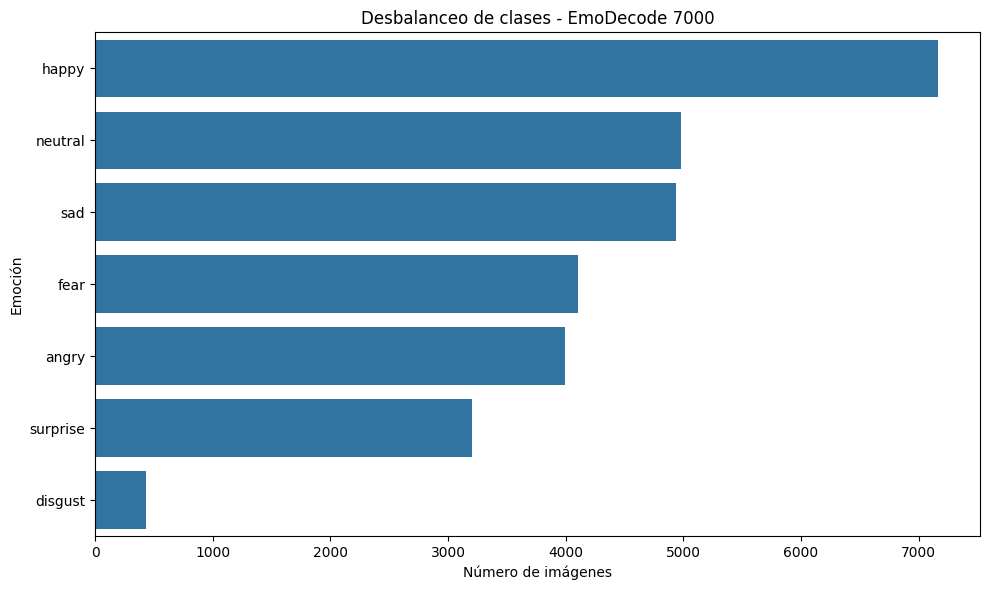

In [10]:

plt.figure(figsize=(10,6))
sns.countplot(data=df_train, y='label', order=df_train['label'].value_counts().index)
plt.title('Desbalanceo de clases - EmoDecode 7000')
plt.xlabel('Número de imágenes')
plt.ylabel('Emoción')
plt.tight_layout()
plt.show()


Tenemos un desbalanceo claro. 

## Train test(val para no liar con el test de kaggle)

In [11]:
train_data, val_data = train_test_split(
    df_train, 
    test_size=0.2, 
    random_state=42, 
    stratify=df_train['label']
)

print(f"Train: {len(train_data)} imágenes")
print(f"Val:   {len(val_data)} imágenes")
print("\nDistribución TRAIN:")
print(train_data['label'].value_counts().sort_index())
print("\nDistribución VAL:")
print(val_data['label'].value_counts().sort_index())


Train: 23056 imágenes
Val:   5765 imágenes

Distribución TRAIN:
label
angry       3194
disgust      349
fear        3282
happy       5731
neutral     3986
sad         3950
surprise    2564
Name: count, dtype: int64

Distribución VAL:
label
angry        799
disgust       87
fear         821
happy       1433
neutral      996
sad          988
surprise     641
Name: count, dtype: int64


Para desbalanceo, usaremos sample weights. Si vemos que no funciona, undersampling

In [12]:
classes = train_data['label'].unique()
classes

array(['neutral', 'happy', 'disgust', 'sad', 'angry', 'surprise', 'fear'],
      dtype=object)

In [13]:
class_weights = compute_class_weight('balanced', classes=classes, y=train_data['label'])
class_weight_dict = dict(zip(classes, class_weights))

print("Pesos para model.fit():")
for label, weight in sorted(class_weight_dict.items()):
    print(f"{label:8}: {weight:.3f}")

Pesos para model.fit():
angry   : 1.031
disgust : 9.438
fear    : 1.004
happy   : 0.575
neutral : 0.826
sad     : 0.834
surprise: 1.285


In [14]:
# Convertir labels de string → números (0,1,2,3...)
le = LabelEncoder()
train_data['label_encoded'] = le.fit_transform(train_data['label'])
val_data['label_encoded'] = le.transform(val_data['label'])

print("Mapeo de emociones → números:")
for i, emotion in enumerate(le.classes_):
    print(f"{i:2}: {emotion}")

print(f"\nEjemplo train_data:")
print(train_data[['id_img', 'label', 'label_encoded']].head())

Mapeo de emociones → números:
 0: angry
 1: disgust
 2: fear
 3: happy
 4: neutral
 5: sad
 6: surprise

Ejemplo train_data:
       id_img    label  label_encoded
17100   19085  neutral              4
12816   29124    happy              3
10974   20800    happy              3
9779    15508    happy              3
4216    26489  disgust              1


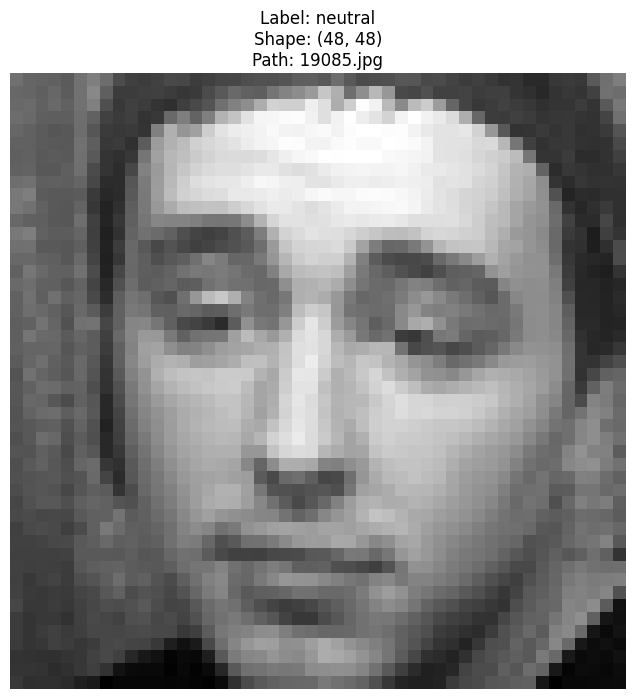

Tipo: uint8, Min: 32, Max: 255


In [15]:
def load_and_show_image(path, label=None, size=(8,8)):
    """Carga imagen grayscale (48,48) y la muestra"""
    img = Image.open(path)
    img_array = np.array(img)
    
    plt.figure(figsize=size)
    plt.imshow(img_array, cmap='gray')
    plt.title(f"Label: {label}\nShape: {img_array.shape}\nPath: {os.path.basename(path)}")
    plt.axis('off')
    plt.show()
    
    print(f"Tipo: {img_array.dtype}, Min: {img_array.min()}, Max: {img_array.max()}")
    return img_array

# Probar con primera imagen
sample_img = load_and_show_image(train_data['path'].iloc[0], train_data['label'].iloc[0])


In [16]:


def simple_batch_generator(df, batch_size=32):
    """Generador simple: carga batch de imágenes + labels"""
    indices = np.random.choice(len(df), batch_size, replace=False)
    batch_X, batch_y = [], []
    
    for idx in indices:
        # Cargar y normalizar imagen
        img = plt.imread(df.iloc[idx]['path'])
        img = img.astype('float32') / 255.0  # 0-1
        batch_X.append(img)
        
        # Label numérico
        batch_y.append(df.iloc[idx]['label_encoded'])
    
    batch_X = np.array(batch_X)[:, :, :, np.newaxis]  # (batch,48,48,1) para grayscale
    batch_y = to_categorical(batch_y, num_classes=7)   # One-hot
    
    return batch_X, batch_y

# Probar con 4 imágenes
X_batch, y_batch = simple_batch_generator(train_data, batch_size=4)

print(f"Shape X: {X_batch.shape}  ← (batch, 48, 48, 1)")
print(f"Shape Y: {y_batch.shape}  ← (batch, 7 clases)")
print(f"X range: {X_batch.min():.3f} - {X_batch.max():.3f}")
print("\nPrimeras labels one-hot:")
print(y_batch[:2])


Shape X: (4, 48, 48, 1)  ← (batch, 48, 48, 1)
Shape Y: (4, 7)  ← (batch, 7 clases)
X range: 0.000 - 1.000

Primeras labels one-hot:
[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


Generar modelo

In [17]:
# Parámetros fijos del dataset
IMG_SHAPE = (48, 48, 1)  # Grayscale
NUM_CLASSES = 7
BATCH_SIZE = 32

print(f"Configuración modelo:")
print(f"- Imágenes: {IMG_SHAPE}")
print(f"- Clases: {NUM_CLASSES}")
print(f"- Batch: {BATCH_SIZE}")
print(f"- Train steps/epoch: {len(train_data)//BATCH_SIZE}")
print(f"- Val steps/epoch: {len(val_data)//BATCH_SIZE}")


Configuración modelo:
- Imágenes: (48, 48, 1)
- Clases: 7
- Batch: 32
- Train steps/epoch: 720
- Val steps/epoch: 180


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import numpy as np

# Data Augmentation solo para train (ligera para caras)
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalizar 0-1
    rotation_range=10,        # Rotar ±10°
    width_shift_range=0.1,    # Shift horizontal 10%
    height_shift_range=0.1,   # Shift vertical 10%
    horizontal_flip=True,     # Flip horizontal (caras)
    zoom_range=0.2,           # Zoom 20%
    fill_mode = "nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Solo normalizar para val

print("DataGenerators creados ✓")
print("Augmentations train:", train_datagen.__dict__.keys())


DataGenerators creados ✓
Augmentations train: dict_keys(['featurewise_center', 'samplewise_center', 'featurewise_std_normalization', 'samplewise_std_normalization', 'zca_whitening', 'zca_epsilon', 'rotation_range', 'width_shift_range', 'height_shift_range', 'shear_range', 'zoom_range', 'channel_shift_range', 'fill_mode', 'cval', 'horizontal_flip', 'vertical_flip', 'rescale', 'preprocessing_function', 'dtype', 'interpolation_order', 'data_format', 'channel_axis', 'row_axis', 'col_axis', '_validation_split', 'mean', 'std', 'zca_whitening_matrix', 'brightness_range'])


In [19]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import numpy as np

def df_generator(df, batch_size, augment_datagen, target_size=(48,48)):
    """Generador para DataFrame con columna 'path'"""
    while True:
        indices = np.random.choice(len(df), batch_size)
        batch_X, batch_y = [], []
        
        for idx in indices:
            # Cargar imagen
            img_path = df.iloc[idx]['path']
            img = load_img(img_path, target_size=target_size, color_mode='grayscale')
            img = img_to_array(img).astype('float32') / 255.0  # (48,48,1)
            
            # Aplicar augmentations
            img = augment_datagen.random_transform(img)
            
            batch_X.append(img)
            batch_y.append(df.iloc[idx]['label_encoded'])
        
        batch_X = np.array(batch_X)
        batch_y = to_categorical(batch_y, 7)
        yield batch_X, batch_y

# Test con 4 imágenes
train_gen = df_generator(train_data, 4, train_datagen)
X, y = next(train_gen)
print(f"Shape X: {X.shape}")
print(f"Shape Y: {y.shape}")
print(f"X range: {X.min():.3f}-{X.max():.3f}")


Shape X: (4, 48, 48, 1)
Shape Y: (4, 7)
X range: 0.003-1.000


In [20]:
# Crear generadores definitivos
BATCH_SIZE = 32
train_generator = df_generator(train_data, BATCH_SIZE, train_datagen)
val_generator = df_generator(val_data, BATCH_SIZE, val_datagen)  # Sin augment

# Calcular steps por epoch
steps_per_epoch = len(train_data) // BATCH_SIZE
val_steps = len(val_data) // BATCH_SIZE

print(f"Generadores listos ✓")
print(f"Train steps/epoch: {steps_per_epoch}")
print(f"Val steps/epoch: {val_steps}")
print(f"Una epoch = {steps_per_epoch * BATCH_SIZE} imágenes train")


Generadores listos ✓
Train steps/epoch: 720
Val steps/epoch: 180
Una epoch = 23040 imágenes train


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Modelo CNN simple para (48,48,1) grayscale
model = Sequential([
    # Block 1
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),
    
    # Block 2  
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),
    
    # Block 3
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),
    
    # Clasificador
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 emociones
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


c:\Users\Sergio\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,148,295 (4.38 MB)

 Trainable params: 1,146,823 (4.37 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [22]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=5, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7
    )
]

# ¡ENTRENAR! (sin class_weight)
history = model.fit(
    train_generator,
    steps_per_epoch=720,
    epochs=50,
    validation_data=val_generator,
    validation_steps=180,
    callbacks=callbacks,
    verbose=1
)

print("Entrenamiento completado ✓")


Epoch 1/50
720/720 ━━━━━━━━━━━━━━━━━━━━ 201s 276ms/step - accuracy: 0.2433 - loss: 2.1540 - val_accuracy: 0.3594 - val_loss: 1.6739 - learning_rate: 0.0010
Epoch 2/50
720/720 ━━━━━━━━━━━━━━━━━━━━ 100s 139ms/step - accuracy: 0.3135 - loss: 1.7442 - val_accuracy: 0.2901 - val_loss: 2.0050 - learning_rate: 0.0010
Epoch 3/50
720/720 ━━━━━━━━━━━━━━━━━━━━ 73s 102ms/step - accuracy: 0.3666 - loss: 1.6219 - val_accuracy: 0.4682 - val_loss: 1.3857 - learning_rate: 0.0010
Epoch 4/50
720/720 ━━━━━━━━━━━━━━━━━━━━ 63s 88ms/step - accuracy: 0.3967 - loss: 1.5505 - val_accuracy: 0.3425 - val_loss: 1.6689 - learning_rate: 0.0010
Epoch 5/50
720/720 ━━━━━━━━━━━━━━━━━━━━ 62s 86ms/step - accuracy: 0.4022 - loss: 1.5297 - val_accuracy: 0.4625 - val_loss: 1.3988 - learning_rate: 0.0010
Epoch 6/50
720/720 ━━━━━━━━━━━━━━━━━━━━ 65s 90ms/step - accuracy: 0.4316 - loss: 1.4715 - val_accuracy: 0.4295 - val_loss: 1.5301 - learning_rate: 0.0010
Epoch 7/50
720/720 ━━━━━━━━━━━━━━━━━━━━ 61s 84ms/step - accuracy: 0.450

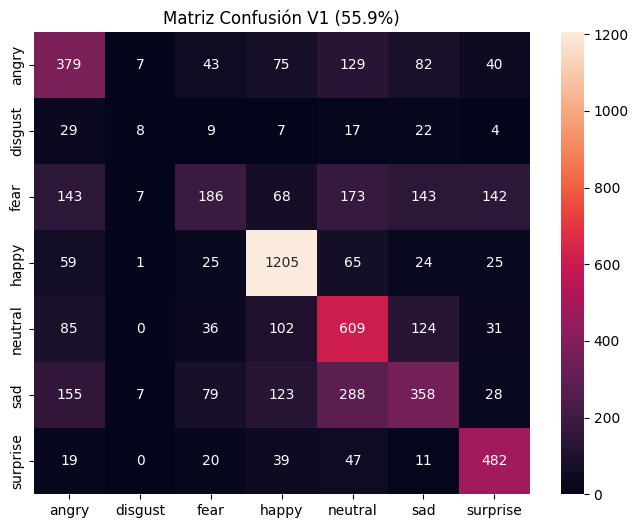

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predicciones en val
val_gen = df_generator(val_data, BATCH_SIZE, val_datagen)
y_true, y_pred = [], []

for i in range(180):  # 1 epoch val
    X, y = next(val_gen)
    pred = model.predict(X, verbose=0)
    y_true.extend(np.argmax(y, axis=1))
    y_pred.extend(np.argmax(pred, axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz Confusión V1 (55.9%)')
plt.show()


In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

# Tamaño de entrada estándar para EfficientNetB0
IMG_SIZE = 224 
BATCH_SIZE = 32 # EfficientNet consume más memoria, quizás necesites bajar a 32 o 16 si usas GPU limitada

# --- Generadores ---
# NOTA: EfficientNet tiene su propio preprocesamiento interno, 
# pero un rescale simple suele funcionar bien como punto de partida.
train_datagen_eff = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen_eff = ImageDataGenerator(preprocessing_function=preprocess_input)

print("Creando generadores para EfficientNet...")
train_generator_eff = train_datagen_eff.flow_from_dataframe(
    dataframe=train_data,
    x_col='path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE), # <-- CAMBIO CRUCIAL: 224x224
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',                 # <-- CAMBIO CRUCIAL: debe ser 'rgb'
    shuffle=True
)

val_generator_eff = val_datagen_eff.flow_from_dataframe(
    dataframe=val_data,
    x_col='path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE), # <-- CAMBIO CRUCIAL
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',                 # <-- CAMBIO CRUCIAL
    shuffle=False 
)

Creando generadores para EfficientNet...
Found 23056 validated image filenames belonging to 7 classes.
Found 5765 validated image filenames belonging to 7 classes.


In [25]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers

# 1. Cargar la base pre-entrenada
# include_top=False significa que NO cargamos la capa final de 1000 clases de ImageNet
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# 2. CONGELAR el modelo base
# Es vital empezar así para no destruir los pesos pre-entrenados con gradientes grandes al inicio.
base_model.trainable = False

# 3. Crear nuestra "cabeza" de clasificación personalizada
model_eff = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), # Convierte los mapas de características 2D en un vector 1D
    layers.Dropout(0.3),             # Un poco de regularización extra
    layers.Dense(7, activation='softmax') # 7 clases de emociones
])

# 4. Compilar
# Usamos un learning rate estándar para empezar
model_eff.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_eff.summary()
# Deberías ver que los "Trainable params" son pocos comparados con el total.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,058,538 (15.48 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [26]:
callbacks_eff = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('efficientnet_b0_frozen.h5', save_best_only=True, monitor='val_accuracy', verbose=1)
]

print("\n--- Iniciando FASE 1 de entrenamiento (Capa base congelada) ---")
history_phase1 = model_eff.fit(
    train_generator_eff,
    epochs=20, # No suelen hacer falta muchas épocas aquí
    validation_data=val_generator_eff,
    callbacks=callbacks_eff,
    verbose=1
)


--- Iniciando FASE 1 de entrenamiento (Capa base congelada) ---
Epoch 1/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.2936 - loss: 1.7456
Epoch 1: val_accuracy improved from None to 0.38283, saving model to efficientnet_b0_frozen.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 619s 848ms/step - accuracy: 0.3313 - loss: 1.6774 - val_accuracy: 0.3828 - val_loss: 1.6038
Epoch 2/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.3770 - loss: 1.5896
Epoch 2: val_accuracy improved from 0.38283 to 0.39237, saving model to efficientnet_b0_frozen.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 620s 859ms/step - accuracy: 0.3838 - loss: 1.5818 - val_accuracy: 0.3924 - val_loss: 1.5679
Epoch 3/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.3940 - loss: 1.5557
Epoch 3: val_accuracy did not improve from 0.39237
721/721 ━━━━━━━━━━━━━━━━━━━━ 620s 860ms/step - accuracy: 0.3956 - loss: 1.5543 - val_accuracy: 0.3901 - val_loss: 1.5639
Epoch 4/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.4042 - loss: 1.5432
Epoch 4: val_accuracy improved from 0.39237 to 0.40225, saving model to efficientnet_b0_frozen.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 621s 861ms/step - accuracy: 0.4021 - loss: 1.5455 - val_accuracy: 0.4023 - val_loss: 1.5424
Epoch 5/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.4022 - loss: 1.5349
Epoch 5: val_accuracy did not improve from 0.40225
721/721 ━━━━━━━━━━━━━━━━━━━━ 637s 883ms/step - accuracy: 0.3986 - loss: 1.5373 - val_accuracy: 0.3925 - val_loss: 1.5824
Epoch 6/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 724ms/step - accuracy: 0.3990 - loss: 1.5388
Epoch 6: val_accuracy improved from 0.40225 to 0.40382, saving model to efficientnet_b0_frozen.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 615s 853ms/step - accuracy: 0.4066 - loss: 1.5282 - val_accuracy: 0.4038 - val_loss: 1.5327
Epoch 7/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.4075 - loss: 1.5324
Epoch 7: val_accuracy improved from 0.40382 to 0.41162, saving model to efficientnet_b0_frozen.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 630s 874ms/step - accuracy: 0.4083 - loss: 1.5309 - val_accuracy: 0.4116 - val_loss: 1.5215
Epoch 8/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 735ms/step - accuracy: 0.4113 - loss: 1.5216
Epoch 8: val_accuracy improved from 0.41162 to 0.42220, saving model to efficientnet_b0_frozen.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 628s 871ms/step - accuracy: 0.4064 - loss: 1.5262 - val_accuracy: 0.4222 - val_loss: 1.5028
Epoch 9/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 731ms/step - accuracy: 0.4151 - loss: 1.5225
Epoch 9: val_accuracy did not improve from 0.42220
721/721 ━━━━━━━━━━━━━━━━━━━━ 625s 867ms/step - accuracy: 0.4082 - loss: 1.5296 - val_accuracy: 0.4120 - val_loss: 1.5284
Epoch 10/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 735ms/step - accuracy: 0.4079 - loss: 1.5221
Epoch 10: val_accuracy did not improve from 0.42220
721/721 ━━━━━━━━━━━━━━━━━━━━ 627s 870ms/step - accuracy: 0.4078 - loss: 1.5250 - val_accuracy: 0.4019 - val_loss: 1.5479
Epoch 11/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.4090 - loss: 1.5158
Epoch 11: val_accuracy improved from 0.42220 to 0.42480, saving model to efficientnet_b0_frozen.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 626s 867ms/step - accuracy: 0.4118 - loss: 1.5199 - val_accuracy: 0.4248 - val_loss: 1.5000
Epoch 12/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.4105 - loss: 1.5291
Epoch 12: val_accuracy did not improve from 0.42480
721/721 ━━━━━━━━━━━━━━━━━━━━ 627s 870ms/step - accuracy: 0.4127 - loss: 1.5243 - val_accuracy: 0.4168 - val_loss: 1.5240
Epoch 13/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.4053 - loss: 1.5198
Epoch 13: val_accuracy did not improve from 0.42480
721/721 ━━━━━━━━━━━━━━━━━━━━ 637s 884ms/step - accuracy: 0.4086 - loss: 1.5223 - val_accuracy: 0.4083 - val_loss: 1.5023
Epoch 14/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.4117 - loss: 1.5262
Epoch 14: val_accuracy did not improve from 0.42480
721/721 ━━━━━━━━━━━━━━━━━━━━ 662s 918ms/step - accuracy: 0.4097 - loss: 1.5277 - val_accuracy: 0.4095 - val_loss: 1.5210
Epoch 15/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.4120 - loss: 1.5158
Epoc

In [ ]:
print("\n--- Preparando FASE 2: Fine-Tuning (Afinado fino) ---")

# 1. Descongelar el modelo base
base_model.trainable = True

# Opcional: A veces se descongelan solo las últimas capas si el B0 completo es inestable.
# for layer in base_model.layers[:-20]: 
#    layer.trainable = False

# 2. RECOMPILAR con un LEARNING RATE MUY BAJO (ej. 1e-5)
# Es vital bajar el LR para no "romper" los pesos ya aprendidos.
model_eff.compile(optimizer=optimizers.Adam(learning_rate=1e-5), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Callbacks para fine-tuning (podemos relajar un poco el EarlyStopping)
callbacks_finetune = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('efficientnet_b0_finetuned.h5', save_best_only=True, monitor='val_accuracy', verbose=1)
]

print("Iniciando FASE 2 de entrenamiento...")
# Entrenamos de nuevo (continuando desde donde se quedó)
history_phase2 = model_eff.fit(
    train_generator_eff,
    epochs=30, 
    validation_data=val_generator_eff,
    callbacks=callbacks_finetune,
    verbose=1
)


--- Preparando FASE 2: Fine-Tuning (Afinado fino) ---
Iniciando FASE 2 de entrenamiento...
Epoch 1/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2092 - loss: 2.1272
Epoch 1: val_accuracy improved from None to 0.35577, saving model to efficientnet_b0_finetuned.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 2733s 4s/step - accuracy: 0.2583 - loss: 1.9536 - val_accuracy: 0.3558 - val_loss: 1.6684 - learning_rate: 1.0000e-05
Epoch 2/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3572 - loss: 1.6761
Epoch 2: val_accuracy improved from 0.35577 to 0.41197, saving model to efficientnet_b0_finetuned.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 2790s 4s/step - accuracy: 0.3709 - loss: 1.6395 - val_accuracy: 0.4120 - val_loss: 1.5205 - learning_rate: 1.0000e-05
Epoch 3/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4095 - loss: 1.5445
Epoch 3: val_accuracy improved from 0.41197 to 0.45343, saving model to efficientnet_b0_finetuned.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 2607s 4s/step - accuracy: 0.4213 - loss: 1.5208 - val_accuracy: 0.4534 - val_loss: 1.4234 - learning_rate: 1.0000e-05
Epoch 4/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4539 - loss: 1.4305
Epoch 4: val_accuracy improved from 0.45343 to 0.47355, saving model to efficientnet_b0_finetuned.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 2614s 4s/step - accuracy: 0.4541 - loss: 1.4319 - val_accuracy: 0.4735 - val_loss: 1.3731 - learning_rate: 1.0000e-05
Epoch 5/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4774 - loss: 1.3719
Epoch 5: val_accuracy improved from 0.47355 to 0.49766, saving model to efficientnet_b0_finetuned.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 2582s 4s/step - accuracy: 0.4815 - loss: 1.3696 - val_accuracy: 0.4977 - val_loss: 1.3198 - learning_rate: 1.0000e-05
Epoch 6/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4963 - loss: 1.3435
Epoch 6: val_accuracy improved from 0.49766 to 0.51206, saving model to efficientnet_b0_finetuned.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 2623s 4s/step - accuracy: 0.4991 - loss: 1.3283 - val_accuracy: 0.5121 - val_loss: 1.2879 - learning_rate: 1.0000e-05
Epoch 7/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5121 - loss: 1.2819
Epoch 7: val_accuracy improved from 0.51206 to 0.52836, saving model to efficientnet_b0_finetuned.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 2765s 4s/step - accuracy: 0.5138 - loss: 1.2832 - val_accuracy: 0.5284 - val_loss: 1.2390 - learning_rate: 1.0000e-05
Epoch 8/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5159 - loss: 1.2609
Epoch 8: val_accuracy improved from 0.52836 to 0.54033, saving model to efficientnet_b0_finetuned.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 2797s 4s/step - accuracy: 0.5226 - loss: 1.2491 - val_accuracy: 0.5403 - val_loss: 1.2198 - learning_rate: 1.0000e-05
Epoch 9/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5364 - loss: 1.2253
Epoch 9: val_accuracy improved from 0.54033 to 0.54224, saving model to efficientnet_b0_finetuned.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 2602s 4s/step - accuracy: 0.5388 - loss: 1.2194 - val_accuracy: 0.5422 - val_loss: 1.2061 - learning_rate: 1.0000e-05
Epoch 10/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5410 - loss: 1.1999
Epoch 10: val_accuracy improved from 0.54224 to 0.55282, saving model to efficientnet_b0_finetuned.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 2773s 4s/step - accuracy: 0.5438 - loss: 1.1979 - val_accuracy: 0.5528 - val_loss: 1.1777 - learning_rate: 1.0000e-05
Epoch 11/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5590 - loss: 1.1662
Epoch 11: val_accuracy improved from 0.55282 to 0.55854, saving model to efficientnet_b0_finetuned.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 2804s 4s/step - accuracy: 0.5599 - loss: 1.1644 - val_accuracy: 0.5585 - val_loss: 1.1709 - learning_rate: 1.0000e-05
Epoch 12/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5663 - loss: 1.1491
Epoch 12: val_accuracy improved from 0.55854 to 0.56947, saving model to efficientnet_b0_finetuned.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 2752s 4s/step - accuracy: 0.5689 - loss: 1.1437 - val_accuracy: 0.5695 - val_loss: 1.1418 - learning_rate: 1.0000e-05
Epoch 13/30
 12/721 ━━━━━━━━━━━━━━━━━━━━ 40:54 3s/step - accuracy: 0.5103 - loss: 1.2130